

### Hypothesis

Define a smoothing technique called **Frequency-Weighted Smoothing** instead of traditional Laplace smoothing where a vector of pseudocounts (instead of a constant) can be used for different feature values. This allows flexibility in weighting certain rare events higher or lower
 
---

### Approach

1. **Baseline: Laplace Smoothing**
   - Adds a constant pseudocount $ \alpha $ ( 1) to all features equally to prevent zero probabilities:
     $$
     P(X_i \mid Y) = \frac{\text{count}(X_i, Y) + \alpha}{\text{count}(Y) + \alpha \cdot |V|}
     $$
   - Limitations: It Assumes uniform importance equally for for all features, which may not work well for datasets with rare features or imbalanced data.

2. **Frequency-Weighted Smoothing**
   - Assigns feature-specific pseudocounts $ \alpha_i $ based on feature frequency or importance:
     $$
     P(X_i \mid Y) = \frac{\text{count}(X_i, Y) + \alpha_i}{\text{count}(Y) + \sum_{j} \alpha_j}
     $$
   - Rare features (low $ \text{count}(X_i, Y) $) receive higher $ \alpha_i $ to stabilize their probability estimates.
   - Common features (high $ \text{count}(X_i, Y) $) receive lower $ \alpha_i $, avoiding over-smoothing.

---

### Expectations

#### Impact on Sparse Datasets (e.g., Volcanoes)
1. **Improved AUC**:
   - In the case of rare features, $ \alpha_i $ provides reliable estimates without overfitting to limited data, improving ranking metrics like AUC
 


In [2]:
# Setup for Paths and Imports
from IPython.display import display
from sting.data import Feature, FeatureType, parse_c45
import os
import sys
import numpy as np
import pandas as pd


# Seting up project paths
cwd = os.getcwd()
project_root = os.path.abspath(os.path.join(cwd, '..'))
src_path = os.path.join(project_root, 'src')
if src_path not in sys.path:
    sys.path.append(src_path)

# Importing NBayes and Logistic Regression functions
from nbayes import nbayes, NaiveBayes
from logreg import *
import util

# Define datasets and parameters
data_path = os.path.join(project_root, '440data')
datasets = {
    'volcanoes': os.path.join(data_path, 'volcanoes'),
    'spam': os.path.join(data_path, 'spam'),
    'voting': os.path.join(data_path, 'voting')
}

# Parse schema and get data
example_dataset_path = datasets['volcanoes']
schema, _, _ = parse_c45(os.path.basename(example_dataset_path), os.path.dirname(example_dataset_path))

In [ ]:

# Defining class for NeBayes with Frequency_Weighted Smoothing 
class NaiveBayesWithFrequency_Weighted(NaiveBayes):
    def __init__(self, data_schema, numb_of_bins, alpha_vector=None, m=1):
        super().__init__(data_schema, numb_of_bins, m)
        self.alpha_vector = alpha_vector if alpha_vector else {'default': m}

    def calculate_feature_probs(self, unique_classes, X_discrete, y):
         # Modify the Frequency_Weighted Smoothing depending on alpha vector
        self.feature_probabilities = {}
        for cls in unique_classes:
            lis=np.where(y == cls)
            cls_idxs = lis[0]
            num_of_class_samples = len(cls_idxs)
            self.feature_probabilities[cls] = {}
            #Extraction of feature values
            for feature_idx in range(X_discrete.shape[1]):
                feature_values = X_discrete[cls_idxs, feature_idx]
                bin_counts = np.zeros(self.numb_of_bins, dtype=int)
                #occurance count of bins
                for value in feature_values:
                    if 0 <= value < self.numb_of_bins:
                        bin_counts[value] += 1
                #smoothed prob 
                self.feature_probabilities[cls][feature_idx] = {}
                alpha = self.alpha_vector.get(feature_idx, self.alpha_vector['default'])

                for bin_idx in range(self.numb_of_bins):
                    probability = (bin_counts[bin_idx] + alpha) / (num_of_class_samples + alpha * self.numb_of_bins)
                    self.feature_probabilities[cls][feature_idx][bin_idx] = probability

    def predict_probs(self, X: np.ndarray):
        """Return probabilities for each class as an array."""
        X_discrete = self.discretize_continuous_features(X)
        probabilities = []

        for x in X_discrete:
            log_probs = self.predict_prob_single_input(x)
            exp_probs = {cls: np.exp(log_probs[cls]) for cls in log_probs}
            total_log_prob = sum(exp_probs.values())
            
            # Handle cases where total_log_prob is zero
            if total_log_prob == 0:
                class_probs = {cls: 1 / len(exp_probs) for cls in exp_probs}  # Equal probabilities as fallback
            else:
                #else normalize the probabilities
                class_probs = {cls: exp_probs[cls] / total_log_prob for cls in exp_probs}
            
            probabilities.append(class_probs[1])  # Assuming class '1' is the positive class

        return np.array(probabilities)

In [4]:
# Defining Experiment Function
def run_smoothing_experiment(data_path, model_class, bins, alpha_vector, cv=True):
    metrics = {'accuracy': [], 'precision': [], 'recall': [], 'auc': []}

    path = os.path.expanduser(data_path)
    file_base = os.path.basename(path)
    root_dir = os.path.dirname(path)
    schema, X, y = parse_c45(file_base, root_dir)
    
    if cv:
        datasets = util.cv_split(X, y, folds=5, stratified=True)
    else:
        datasets = ((X, y, X, y),)

    for X_train, y_train, X_test, y_test in datasets:
        model = model_class(schema, bins, alpha_vector)
        model.fit(X_train, y_train)
        y_pred = model.predict(X_test)
        
        metrics['accuracy'].append(util.accuracy(y_test, y_pred))
        metrics['precision'].append(util.precision(y_test, y_pred))
        metrics['recall'].append(util.recall(y_test, y_pred))
        metrics['auc'].append(util.auc(y_test, model.predict_probs(X_test)))

    return {key: np.mean(values) for key, values in metrics.items()}

In [ ]:
# Experimental Parameters
laplace_smoothing = 1
Frequency_Weighted_alpha_vector = {'default': 0.1, 1: 1.0}  # Customize this as needed
bins = 5

# Running Experiments
results = []
for dataset_name, dataset_path in datasets.items():
    print(f"Running experiments on {dataset_name} dataset")

    # Applying Laplace Smoothing 
    laplace_metrics = run_smoothing_experiment(dataset_path, NaiveBayesWithFrequency_Weighted, bins, alpha_vector={'default': laplace_smoothing})
    laplace_metrics.update({"Dataset": dataset_name, "Smoothing": "Laplace"})
    results.append(laplace_metrics)

    # Frequency_Weighted Smoothing Experiment
    Frequency_Weighted_metrics = run_smoothing_experiment(dataset_path, NaiveBayesWithFrequency_Weighted, bins, alpha_vector=Frequency_Weighted_alpha_vector)
    Frequency_Weighted_metrics.update({"Dataset": dataset_name, "Smoothing": "Frequency_Weighted"})
    results.append(Frequency_Weighted_metrics)

# Display Results
results_df = pd.DataFrame(results)
display(results_df)


Running experiments on volcanoes dataset
Running experiments on spam dataset
Running experiments on voting dataset


,accuracy,precision,recall,auc,Dataset,Smoothing
0,0.604668,0.449678,0.719355,0.576651,volcanoes,Laplace
1,0.622591,0.455750,0.611248,0.663949,volcanoes,Frequency_Weighted
2,0.706433,0.736510,0.826290,0.753182,spam,Laplace
3,0.704359,0.733725,0.827831,0.750289,spam,Frequency_Weighted
4,0.977348,0.980238,0.969487,0.994296,voting,Laplace
5,0.977348,0.980238,0.969487,0.994284,voting,Frequency_Weighted


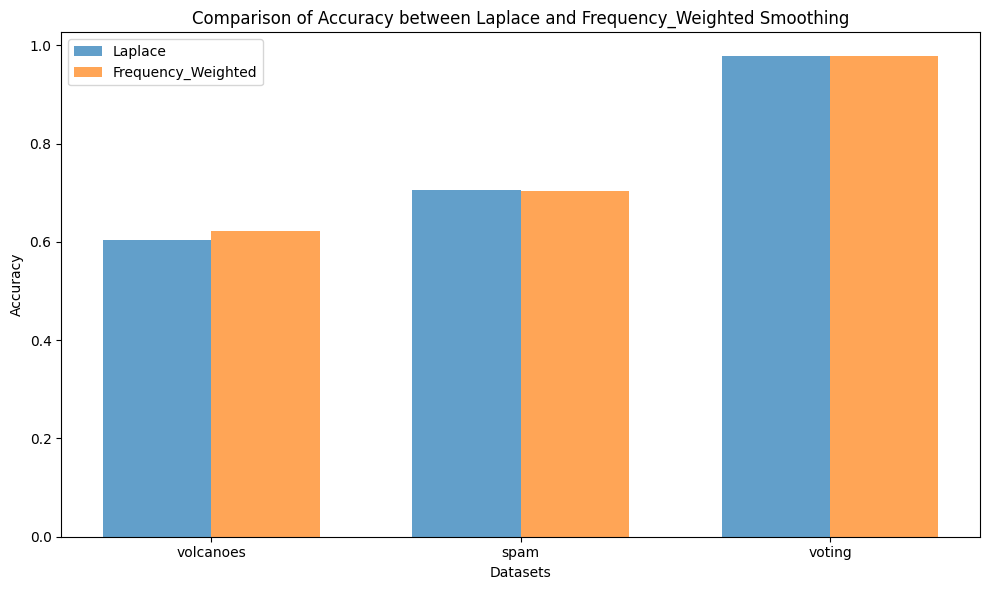

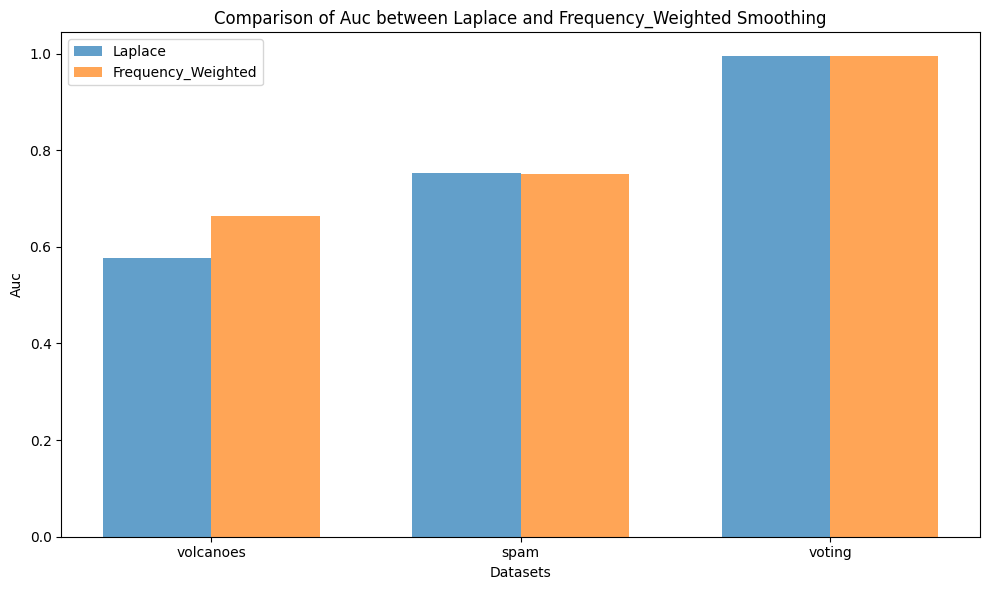

In [42]:
import matplotlib.pyplot as plt

# Function to plot comparisons for Accuracy and AUC
def plot_accuracy_and_auc(results_df):
    """
    Ploting a comparison of Accuracy and AUC for Laplace and Frequency_Weighted smoothing.

    """
    for metric in ["accuracy", "auc"]:
        datasets = results_df['Dataset'].unique()
        laplace_values = results_df[results_df['Smoothing'] == 'Laplace'][metric].values
        Frequency_Weighted_values = results_df[results_df['Smoothing'] == 'Frequency_Weighted'][metric].values

        x = range(len(datasets))  # Number of datasets
        width = 0.35  # Bar width

        # Plotting
        plt.figure(figsize=(10, 6))
        plt.bar(x, laplace_values, width, label='Laplace', alpha=0.7)
        plt.bar([p + width for p in x], Frequency_Weighted_values, width, label='Frequency_Weighted', alpha=0.7)

        # Adding labels and titles
        plt.xlabel('Datasets')
        plt.ylabel(metric.capitalize())
        plt.title(f'Comparison of {metric.capitalize()} between Laplace and Frequency_Weighted Smoothing')
        plt.xticks([p + width / 2 for p in x], datasets)
        plt.legend()
        plt.tight_layout()
        plt.show()

# Calling the plot function
plot_accuracy_and_auc(results_df)




## Experiment Results Summary

1. **Volcanoes Dataset**:
   - **Accuracy**: Accuracy increases after the implementation of Frequency-Weighted Smoothing.
   - **AUC**: AUC shows clearly distinguish between classess.
2. **Spam and Voting Datasets**:
   - **Accuracy**: Experiance no change , shows similar results to laplace smoothing.
   - **AUC**: A slight change , not much , can't noticable.

---

## Reasons :-
### 1. Volcanoes Dataset
- In volcanoes dataset some features are hard to classify .Here Frequency -Weighted smoothing plays an intesting role by assigning some pseudo counts , which improve estimate for these critical or rare features.
  
**Equation**:
$$
P(X_i \mid Y = c) = \frac{\text{count}(X_i, c) + \alpha_i}{\text{count}(Y = c) + \sum_{j} \alpha_j}
$$
- For rare features ($\text{count}(X_i, c)$ small), $\alpha_i$ used to smooth the probability to overcome from issues like zero.

**Impact on AUC**:
$$
\text{AUC} = \frac{1}{N_{\text{pos}} \cdot N_{\text{neg}}} \sum_{y_{\text{pos}} > y_{\text{neg}}} 1
$$
- Ranking of both Negative and Positive examples have seems better because of the improvement in estimate of probabilities for sparse features.

